----
# Data EDA
----

## Set Up
----

In [125]:
import numpy as np
import pandas as pd

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

## Utility Functions
----

In [126]:
def plt_adj_close(dataframe, aggregation):
    plt.figure(figsize=(12, 6))
    plt.plot(dataframe.index, dataframe['Adj Close'], label=f'{aggregation} Adjusted Close')
    plt.title(f'{aggregation} Adjusted Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.show()

## Data Loading
----

In [127]:
msft_df = pd.read_csv('../../data/microsoft_data_cleaned.csv', index_col=0)

In [128]:
msft_df

,Open,High,Low,Close,Adj Close,Volume
2019-07-29,141.500000,141.509995,139.369995,141.029999,134.499710,1.660590e+07
2019-07-30,140.139999,141.220001,139.800003,140.350006,133.851212,1.684650e+07
2019-07-31,140.330002,140.490005,135.080002,136.270004,129.960098,3.859880e+07
2019-08-01,137.000000,140.940002,136.929993,138.059998,131.667221,4.055750e+07
2019-08-02,138.089996,138.320007,135.259995,136.899994,130.560913,3.079160e+07
...,...,...,...,...,...,...
2024-07-25,428.799988,429.799988,417.510010,418.399994,418.399994,2.994380e+07
2024-07-26,418.200012,428.920013,417.269989,425.269989,425.269989,2.356650e+07
2024-07-27,422.650004,429.996673,419.748057,426.313324,426.313324,1.841836e+07
2024-07-28,427.099996,431.073334,422.226125,427.356659,427.356659,1.327022e+07


## Checking datatypes
---

In [129]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1828 entries, 2019-07-29 to 2024-07-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1828 non-null   float64
 1   High       1828 non-null   float64
 2   Low        1828 non-null   float64
 3   Close      1828 non-null   float64
 4   Adj Close  1828 non-null   float64
 5   Volume     1828 non-null   float64
dtypes: float64(6)
memory usage: 100.0+ KB


### Reset Date to be datetime type

In [130]:
msft_df.index = pd.to_datetime(msft_df.index)

In [131]:
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2019-07-29 to 2024-07-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1828 non-null   float64
 1   High       1828 non-null   float64
 2   Low        1828 non-null   float64
 3   Close      1828 non-null   float64
 4   Adj Close  1828 non-null   float64
 5   Volume     1828 non-null   float64
dtypes: float64(6)
memory usage: 100.0 KB


In [132]:
msft_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Exploring Seasonality using Adjusted Close Value
---

Using adjusted close instead of close since adjusted close takes into account some events which affect the stocks price but do not influence the stocks performance such as:

1. Dividends: Stock price usually drops when companies pay dividends, adjusted close takes into account dividends while close does not.
2. Stock Splits: Number of shares increases and the price of the stock usually decreases proportionally, adjsuted close accounts for this and ensures the stock price historically is comparable to the current stock price.

Adjusted close allows for a more accurate measurement of a stock's historic price as it considers all factors affecting the stock's value, not just its trading activity.

### Daily Plot

In [133]:
daily_msft_df = msft_df.resample('D').mean()

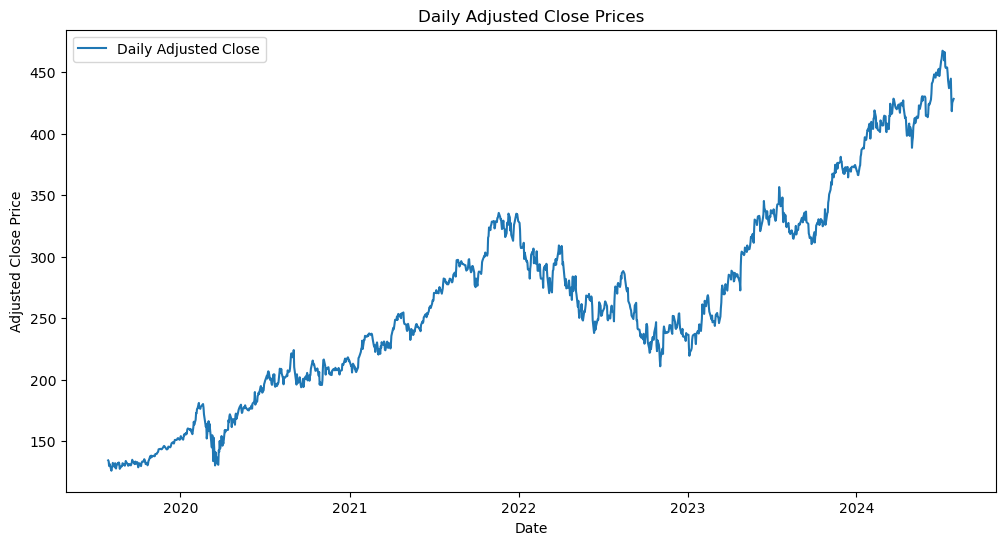

In [134]:
plt_adj_close(daily_msft_df, 'Daily')

**Plot Description:**

Overall, Microsoft's stock price shows a clear upward trend over the 5-year period, reflecting positive company growth.

A notable dip is observed between 2022 and 2023, which may be due to the economic impact of the Russia-Ukraine war. This event contributed to market instability and inflation, both of which plaued a role in the decline in tech stocks which fell by more than 30% in 2022 [1]. The increased volatility during this period also shows market's reaction to these disruptive factors.

From 2023, Microsoft’s stock shows signs of recovery, likely due to a stabilsation in market conditions leading to greater investor confidence. This upward trend could also be driven by the release of new products/updates.

[1] https://www.forbes.com/sites/qai/2023/01/19/why-were-tech-stocks-down-in-2022-and-how-long-will-the-slump-last/#:~:text=Key%20takeaways%3A,inflation%20and%20uncertain%20economic%20conditions.


### Weekly Plot

In [135]:
# Aggregate to weekly frequency
weekly_msft_df = msft_df[['Adj Close']].resample('W').mean()

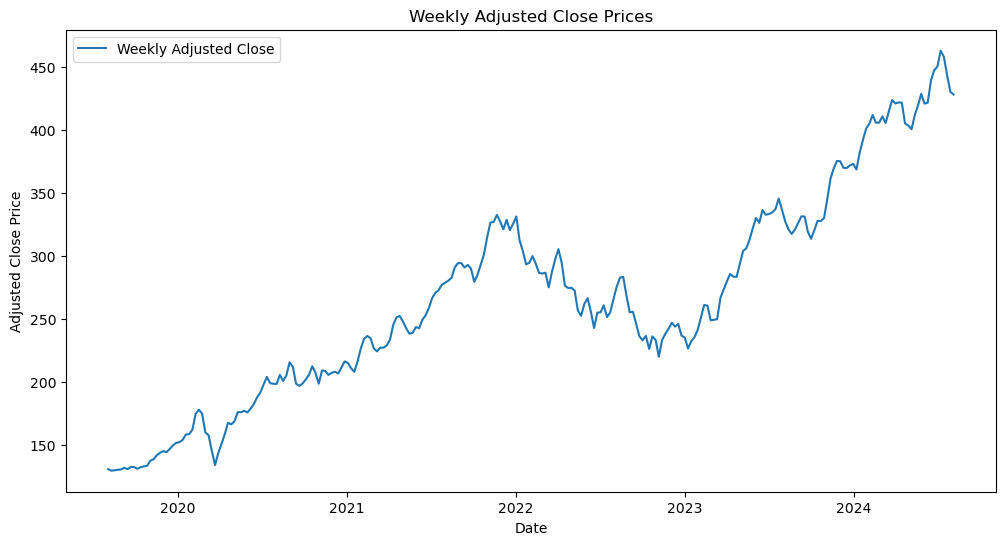

In [136]:
plt_adj_close(weekly_msft_df, 'Weekly')

**Plot Description:**

The weekly plot of adjusted close prices closely follows the daily plot. Underlying trends and patterns identified are similar for both daily and weekly timeframes.

The weekly aggregation using resampling smooths out the fluctatuations we see in the daily plot. This makes the overall trends clearer and easier to follow.

### Monthly Plot

In [137]:
monthly_msft_df = msft_df[['Adj Close']].resample('MS').mean()

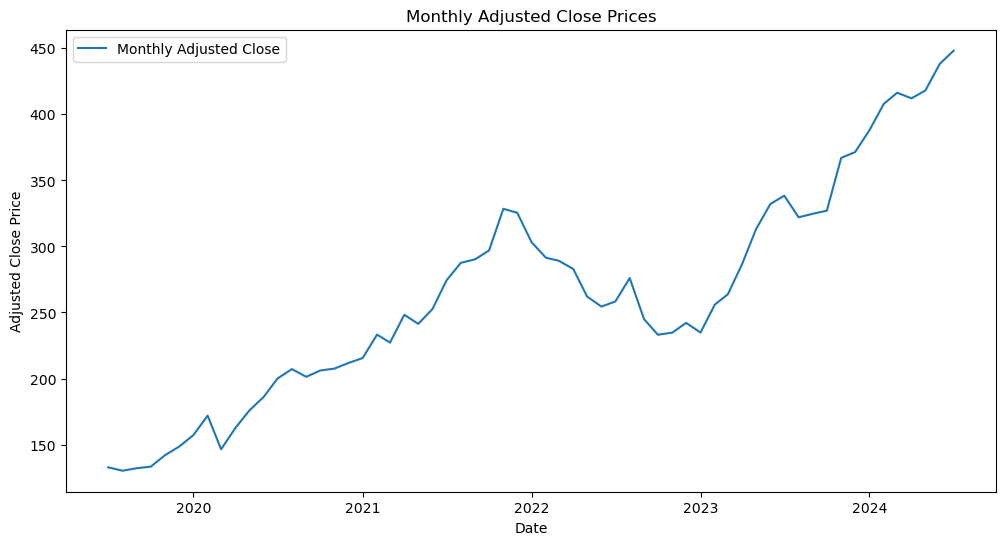

In [138]:
plt_adj_close(monthly_msft_df, 'Monthly')

#### Seasonal Plot

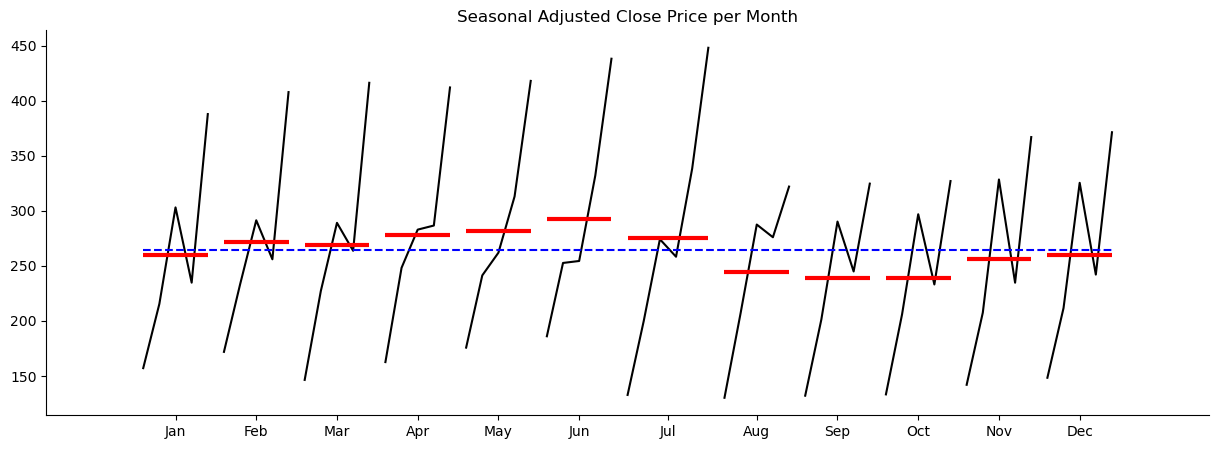

In [139]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(15, 5))

# create the seasonal plot
month_plot(monthly_msft_df["Adj Close"], ax=plt.gca())

# adding a horizontal line for the mean
plt.hlines(y=monthly_msft_df.mean(),  xmin=0, xmax=60, color='blue', linestyles='--')

plt.title("Seasonal Adjusted Close Price per Month")
sns.despine()
plt.show()

**Plot Description:**

The plot above explores the seasonality of the stock close prices over the 5 year period. 

**Key insights:**

- April to July show higher than average close prices with a peak June
    - Steady increase from April to June in avergae adjusted close prices, this suggests stronger market performance for Microsoft in the spring to summer months.
    - To investigate if there any release or events where new products are unveiled, both could be reasons which drive the stock price up.

- August to December show lower than average close prices
    - Investors could be choosing to sell their stocks during this time after their gain
    - See if there is a simialar trend in tech stocks as a whole as this would influence Microsofts stock prices.

- Decemeber to January show recovery 
    - A slight upward trend from November to January
    - Could be due to Christmas, there is a tendency for stock prices to rise in the final week of Decemeber and the first few days of January.
    - Greater optimism at the start of the year as end of the year financial reports tend to include future steps which could attract investors/drive stocks up.

#### Exploring Deviations from the Mean

In [140]:
# monthly average
monthly_mean = monthly_msft_df.groupby(monthly_msft_df.index.month_name()).mean()

# relative deviation from the overall mean
monthly_mean_diff = (monthly_mean - monthly_mean.mean())/monthly_mean

# month names in right order- forcing start to be January
month_names = pd.date_range(start='2019-01', freq='M', periods=12).month_name()

# reorder columns to follow the month order
monthly_mean_diff = monthly_mean_diff.loc[month_names]

monthly_mean_diff

,Adj Close
January,-0.016327
February,0.029954
March,0.017225
April,0.052349
May,0.064246
June,0.098293
July,0.041317
August,-0.079097
September,-0.105894
October,-0.103032


In [141]:
fig = px.bar(monthly_mean_diff)

fig.update_layout(
    yaxis_title="", 
    yaxis_tickformat = '%',
    xaxis_title="",
    title="Monthly deviation from Mean(%)",
    showlegend=False,
)
fig.show()

**Plot Description:**

**June: Highest Positive Deviation:**

- June shows the highest positive deviation form the mean adjusted close price. This sugests 
June presents a time of strong market performance. To investigate if June is the time Microsoft announces major products or updates as this could be the reason we see an uptick in closing price.

**September: Highest Negative Deviation**

-  September shows the highest negative deviation from the mean, reflecting a notable drop in Microsoft’s stock price compared to its average closing price for the 5 year period. Septemeber typically marks the end of summer which may bring out slower business, this could contribute to weaker stock performance.


## Exporting out daily date to be used in baseline forecasting
----

In [145]:
daily_msft_df.to_csv('../../data/daily_data_clean.csv')

## Seasonal-Trend Decomposition
----

Seasonal trend decomposition breaks down the timeseries into three elements:

1. Trend 
    - Used to show long-term patterns in the data.
    - Usually used to indicate whether data is on the rise, decline or remains cosntant over time.
2. Seasonality
    - Used to capture short-term repeating cycles in the data such as weekly or monthly patterns.
3. Residuals
    - Captures noise in the data.
    - Usually represents anomalies that are not explained by trend or seasonality.


The objective of this project is to to forecast future Microsft stock prices and trends, I thought it best to not aggregate my data into weekly, monthly levels and continue with only looking at daily stock prices. Daily data offers granularity, since the stock martket is highly volatile using daily data would be able to capture more insights. Hopefully, this will lead to a more robust and accurate model.

### Daily


In [146]:
# decompose the time series
decomposition = tsa.seasonal_decompose(daily_msft_df['Adj Close'], model='additive')

In [147]:
# add the decomposition data

daily_msft_df["Trend"] = decomposition.trend
daily_msft_df["Seasonal"] = decomposition.seasonal
daily_msft_df["Residual"] = decomposition.resid

daily_msft_df.head(10)

,Open,High,Low,Close,Adj Close,Volume,Trend,Seasonal,Residual
2019-07-29,141.500000,141.509995,139.369995,141.029999,134.499710,16605900.0,NaN,-0.172463,NaN
2019-07-30,140.139999,141.220001,139.800003,140.350006,133.851212,16846500.0,NaN,-0.304873,NaN
2019-07-31,140.330002,140.490005,135.080002,136.270004,129.960098,38598800.0,NaN,0.118229,NaN
2019-08-01,137.000000,140.940002,136.929993,138.059998,131.667221,40557500.0,131.026885,0.088754,0.551582
2019-08-02,138.089996,138.320007,135.259995,136.899994,130.560913,30791600.0,129.825230,0.221445,0.514238
2019-08-03,136.493332,136.856669,133.766663,135.336665,129.069984,34777600.0,129.054097,0.092329,-0.076442
2019-08-04,134.896667,135.393331,132.273331,133.773336,127.579056,38763600.0,128.919218,-0.043420,-1.296742
2019-08-05,133.300003,133.929993,130.779999,132.210007,126.088127,42749600.0,129.032303,-0.172463,-2.771713
2019-08-06,133.800003,135.679993,133.210007,134.690002,128.453278,32696700.0,129.142663,-0.304873,-0.384512
2019-08-07,133.789993,135.649994,131.830002,135.279999,129.015945,33414500.0,129.378820,0.118229,-0.481104


In [148]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_msft_df.index, y=daily_msft_df[col]),
        row=i+1,
        col=1
        
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**Plot Description:**

Hard to seasonality over the 5 years for daily data, will reduce the date range to the previous year and a half to inspect the seasonality. This will also ensure focus on the most recent trends in the stock market.

In [149]:
daily_msft_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2019-07-29 to 2024-07-29
Freq: D
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1828 non-null   float64
 1   High       1828 non-null   float64
 2   Low        1828 non-null   float64
 3   Close      1828 non-null   float64
 4   Adj Close  1828 non-null   float64
 5   Volume     1828 non-null   float64
 6   Trend      1822 non-null   float64
 7   Seasonal   1828 non-null   float64
 8   Residual   1822 non-null   float64
dtypes: float64(9)
memory usage: 142.8 KB


In [150]:
daily_24_msft_df = daily_msft_df.loc[(daily_msft_df.index >= '2023-01-01'), ['Adj Close']]


In [151]:
daily_24_msft_df

,Adj Close
2023-01-01,236.727745
2023-01-02,236.668491
2023-01-03,236.609238
2023-01-04,226.259186
2023-01-05,219.553345
...,...
2024-07-25,418.399994
2024-07-26,425.269989
2024-07-27,426.313324
2024-07-28,427.356659


In [152]:
# decompose the time series
decomposition = tsa.seasonal_decompose(daily_24_msft_df['Adj Close'], model='additive')

In [153]:
# add the decomposition data

daily_24_msft_df["Trend"] = decomposition.trend
daily_24_msft_df["Seasonal"] = decomposition.seasonal
daily_24_msft_df["Residual"] = decomposition.resid

daily_24_msft_df.head(10)

,Adj Close,Trend,Seasonal,Residual
2023-01-01,236.727745,NaN,0.045244,NaN
2023-01-02,236.668491,NaN,-0.160435,NaN
2023-01-03,236.609238,NaN,-0.366944,NaN
2023-01-04,226.259186,228.688672,-0.252102,-2.177384
2023-01-05,219.553345,226.810820,0.041674,-7.299149
2023-01-06,222.140869,225.044427,0.434948,-3.338506
2023-01-07,222.861826,223.530574,0.257614,-0.926362
2023-01-08,223.582784,224.471614,0.045244,-0.934074
2023-01-09,224.303741,226.757204,-0.160435,-2.293028
2023-01-10,226.012268,228.774732,-0.366944,-2.395520


In [154]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=daily_24_msft_df.index, y=daily_24_msft_df[col]),
        row=i+1,
        col=1
        
    )

fig.update_layout(height=800, width=1200, showlegend=False)
fig.show()

**Plot Description:**

**TREND PLOT**

Throughout 2023, there is a clear upward trend in stock prices for Microsoft suggesting solid company growth. 

**SEASONAL PLOT**

Now able to see the seasanlity of data from 2023. 

The seasonal plot shows the MSFT stock ranges drom 0.5 to -0.5 with peaks observed on Fridays and dips observed on Tuesdays. On average, Microsofts stock price is 0.5 units higher than the overall average on Fridays and is 0.5 lower than the overall mean on Tuesdays.

Peaks seen on Fridays suggests there is a consistent pattern of higher stock prices on Friday in comaprison to other trading days. This could be due to the following reasons:

- **Weekend Effect:** Refers to the tendency of stock prices to rrise on the last trading day of the week (Friday).
- **Buying Activity:** Before the weekend begins, investors show a higher demand in buying stocks due to events which occured in the business week or may be in anticipation of good news over the weekend. An increase in demand drives the price of the stock up.
- **End of the Week:** Investors may set thier portfolio at the end of each week to prepare for the following week of trading.

Dips in stock prices on Tuesdays could be due:

- **Reassessment by investors:** Investors may reassess their porfolio midweek and this may drive the stock prices down.
- **Volume:** Be interseting to investigate how the volume of stocks differs throughout the business week, if there increased activity mid-week this could drive prices down since higher activity infers greater volatility in the stock market.

**Additive Seasonality**

In addition,, the seasonality in the data does not seem to be affected by the overall trend. This suggests that the model is showing additive components of seasonality. since the seasonal effect does not follow ups and downs in the trend.

**RESIDUAL PLOT**

The residuals still shows some seasonality. In general, it would be ideal to have that information captured by the seasonal component. 

Variance in the residuals does not seem to be constant suggesting heteroscedasticity. 

ADDITIVE AS FLUCTUATIONS DO NOT APPRAT TO BE DEPENDENT ON THE LEVEL OF TIME SERIES, variance does not scale with the series so not multiplocative


## Stationarity
----

Many forecasting methods require data to be stationary, this means the mean and varaince of the data do not change overtime. 

Residulas in timeseries data should show stationarity however in the plot above this is not seen. To address this, we can use seasonal differencing and assess after applying this technique whether the data becomes stationary.

### Seasonal Differencing

Seasonal differencing is used in cases where seasonal effects are seen in the dataset. For this project, this is observed in the residual plot for the daily stock prices. This method removes/reduces seasonality by subtracting the value of the time series at a previous seasonal period from the current value.

The first step to seasonal differencing is to decide on a seasonal period. From the seasonal decomposition of the daily data (filtered date range) above, the same pattern repeats each week and so 7 days is the seasonal period. 

In [155]:
daily_24_msft_df['seasonal_difference'] = daily_24_msft_df['Adj Close'].diff(7)

In [156]:
daily_24_msft_df[['Adj Close', 'seasonal_difference']].head(10)

,Adj Close,seasonal_difference
2023-01-01,236.727745,NaN
2023-01-02,236.668491,NaN
2023-01-03,236.609238,NaN
2023-01-04,226.259186,NaN
2023-01-05,219.553345,NaN
2023-01-06,222.140869,NaN
2023-01-07,222.861826,NaN
2023-01-08,223.582784,-13.144961
2023-01-09,224.303741,-12.364750
2023-01-10,226.012268,-10.596970


**Comment:**

New column seasonal differnce. Each value in this column is an adjusted `Adj Close` value, it is `Adj Close` of a particular day minus the `Adj Close` value one week prior. This is why there are NaN vayes for the first 7 rows. These NaNs will have to dealt with in the next stage.

By performing seasonal differncing, the weekly repeating seasonal component seen should be removed. 

In [157]:
daily_24_msft_df = daily_24_msft_df.dropna()

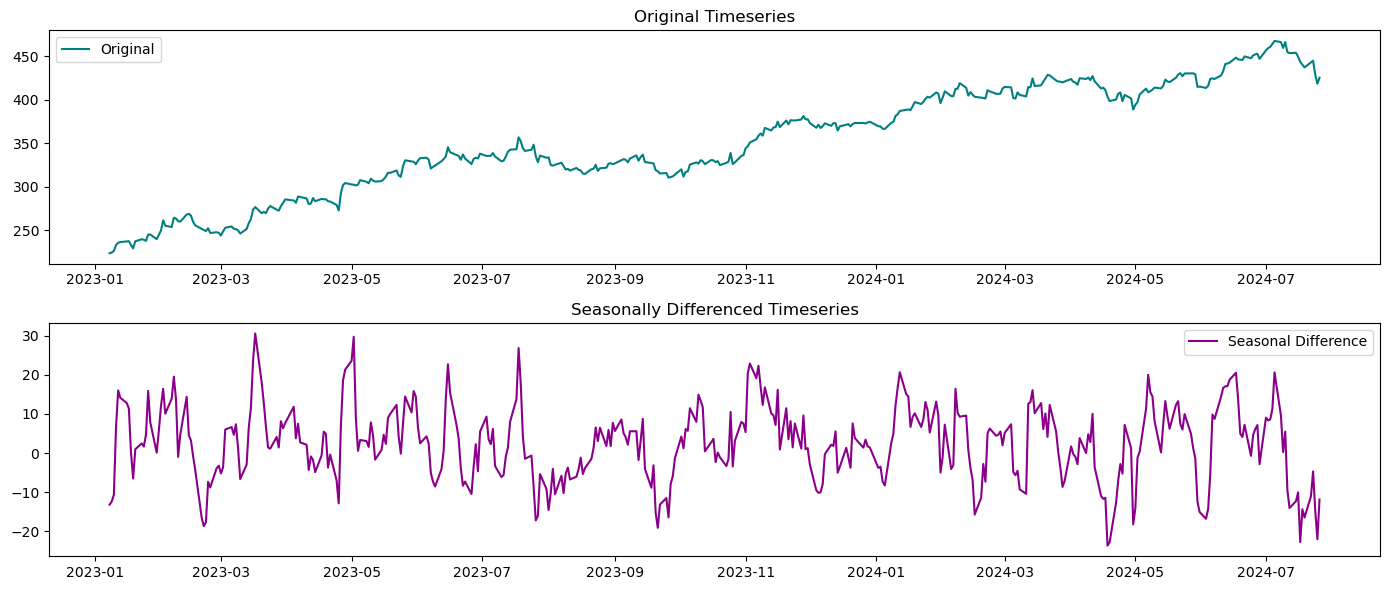

In [158]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(daily_24_msft_df['Adj Close'], label='Original', color= 'teal')
plt.title('Original Timeseries')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(daily_24_msft_df['seasonal_difference'], label='Seasonal Difference', color='darkmagenta')
plt.title('Seasonally Differenced Timeseries')
plt.legend()

plt.tight_layout()
plt.show()

### Hypothesis Testing using ADF

ADF stands for Augmented Dickey-Fuller. It is a statistical test to determine if a given timeseries data is stationary. 

Test Hypotheses:

**Null Hypothesis H0:** Timeseries data is NOT stationary

**Alternate Hypothesis H1:** Timeseries data is stationary

In [159]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_24_msft_df['seasonal_difference'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -5.086561105358414
p-value: 1.4918028607412261e-05


**Comment:** 

p-value is much less than 0.05 and so the null hypothesis is rejected. This means there is strong evidence to suggest that the data is now stationary after performing seasonal differencing.

Now the timeseries data is ready for forecasting.


## Apply Seasonal Differencing for all data
---

In [160]:
daily_msft_df['seasonal_difference'] = daily_msft_df['Adj Close'].diff(7)

In [161]:
daily_msft_df[['Adj Close', 'seasonal_difference']].head(10)

,Adj Close,seasonal_difference
2019-07-29,134.499710,NaN
2019-07-30,133.851212,NaN
2019-07-31,129.960098,NaN
2019-08-01,131.667221,NaN
2019-08-02,130.560913,NaN
2019-08-03,129.069984,NaN
2019-08-04,127.579056,NaN
2019-08-05,126.088127,-8.411583
2019-08-06,128.453278,-5.397934
2019-08-07,129.015945,-0.944153


In [162]:
daily_msft_df = daily_msft_df.dropna()

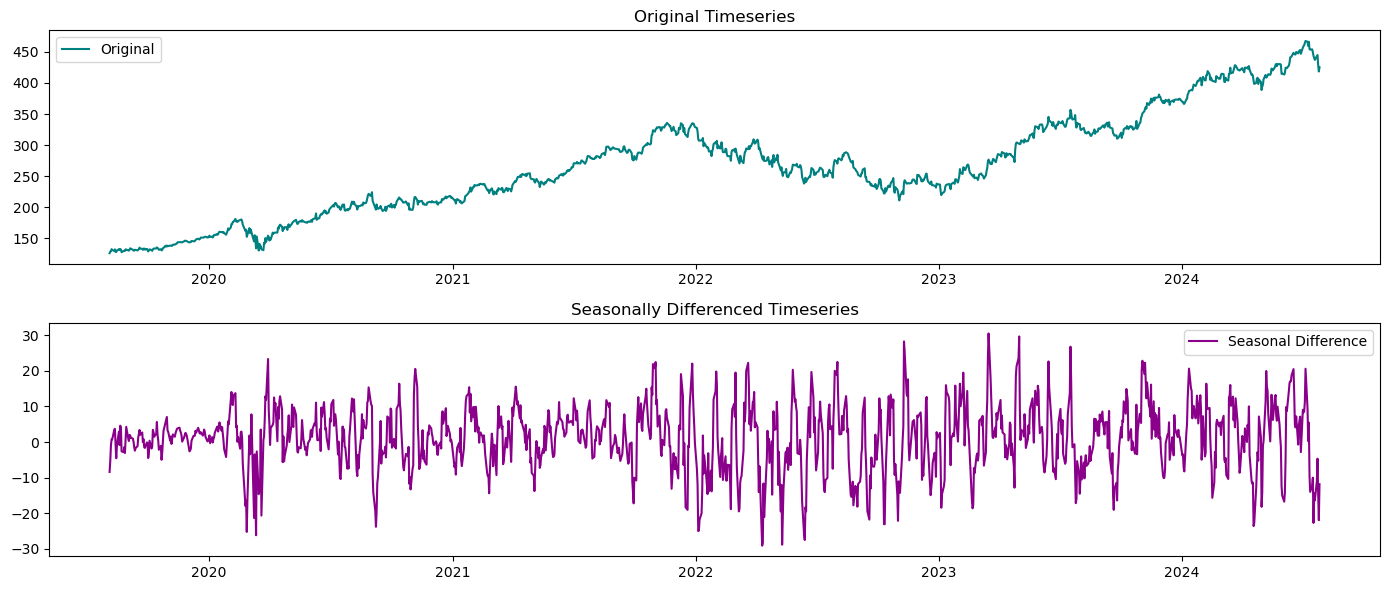

In [163]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(daily_msft_df['Adj Close'], label='Original', color= 'teal')
plt.title('Original Timeseries')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(daily_msft_df['seasonal_difference'], label='Seasonal Difference', color='darkmagenta')
plt.title('Seasonally Differenced Timeseries')
plt.legend()

plt.tight_layout()
plt.show()



**Plot Description:**

Visualising the data after applying seasonal differencing to see if there is any visible trend remains in the data.

Looks like there is constant varaince in the data and no visible trend indicating that there is data is staionary and the differencing was effective.

**to double check:**
Remaining Trends: Check if there’s still an evident upward or downward trend. If so, further differencing or transformation might be needed.

Seasonality: Look for any repeating patterns at the seasonal frequency. If seasonality is still present, you might need to re-evaluate your seasonal differencing parameters.

Stationarity: Ideally, the differenced series should appear more stationary. If the plot shows constant variance and no trend, it indicates that the differencing was effective.

### Hypothesis Testing for Seasonality using ADF

In [106]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_msft_df['seasonal_difference'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -8.06108014135031
p-value: 1.642365064152087e-12


## Saving Stationary Daily Stock Data
---

In [164]:
daily_msft_df.to_csv('../../data/daily_data_stationary.csv')

## Conclusion
----

TODOs

- intro/conc
- plot descriptions
